In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision

In [2]:
dataset = pd.read_csv("dataset/fer2013/fer2013.csv")
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
def parse_pixels(pixel_str):
    pixels = np.array(pixel_str.split(), dtype=np.float32)
    return pixels.reshape(48, 48)

dataset['pixels'] = dataset['pixels'].apply(parse_pixels)

In [4]:
# stratify ensures that the distribution of emotions in the train and test sets are similar
train_data, test_data = train_test_split(dataset, test_size=0.2, stratify=dataset['emotion'], random_state=42)

In [5]:
class EmotionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx]['pixels']
        label = self.data.iloc[idx]['emotion']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((32, 32)),  # Resize for uniform input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Create datasets
train_dataset = EmotionDataset(train_data, transform=transform)
test_dataset = EmotionDataset(test_data, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### define nn

In [7]:
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 7)  # 7 classes for emotion
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### train

In [8]:
import torch.optim as optim

# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print("Training Complete.")

Epoch 1, Loss: 1.5767694641327805
Epoch 2, Loss: 1.354008535300703
Epoch 3, Loss: 1.2254796133009522
Epoch 4, Loss: 1.119326252913422
Epoch 5, Loss: 1.0119287678951145
Epoch 6, Loss: 0.901262489684706
Epoch 7, Loss: 0.7927589077992003
Epoch 8, Loss: 0.6780055957143185
Epoch 9, Loss: 0.5718239892464969
Epoch 10, Loss: 0.46697347797868244
Training Complete.


### evaluate

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 52.284758985789914%


Displaying test images:


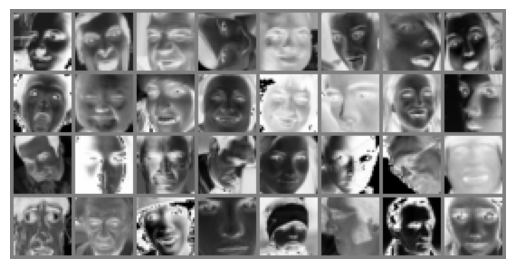

Predicted labels:  [3, 6, 3, 4, 5, 4, 3, 4, 6, 3, 3, 3, 3, 1, 3, 6, 3, 1, 0, 0, 3, 5, 1, 0, 6, 1, 3, 5, 5, 0, 1, 4]
True labels:       [3, 4, 3, 3, 3, 4, 6, 6, 6, 3, 3, 3, 3, 1, 3, 6, 3, 1, 2, 4, 5, 1, 0, 6, 4, 5, 3, 1, 1, 0, 5, 4]


In [14]:
import torch

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

# Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (assuming mean=0.5, std=0.5 used during normalization)
    npimg = img.cpu().numpy()  # Ensure the image is moved to the CPU for display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()

# Visualize predictions for a batch of test images
def visualize_predictions(model, test_loader, class_labels):
    # Determine device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to the appropriate device
    model.to(device)
    model.eval()  # Ensure the model is in evaluation mode
    
    # Fetch a batch of test data
    try:
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)
        
        # Display images in a grid (convert images back to CPU for visualization)
        print("Displaying test images:")
        imshow(torchvision.utils.make_grid(images.cpu()))
        
        # Perform predictions
        with torch.no_grad():
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class indices with max scores
        
        # Convert predicted indices to class names
        predicted_labels = [class_labels[idx] for idx in predicted.cpu()]  # Move predictions to CPU
        true_labels = [class_labels[idx] for idx in labels.cpu()]  # Move labels to CPU
        
        # Display predictions and ground truth
        print("Predicted labels: ", predicted_labels)
        print("True labels:      ", true_labels)
    
    except StopIteration:
        print("No data available in the test loader.")

# Example usage
# Replace `model`, `test_loader`, and `class_labels` with your actual data
visualize_predictions(model, test_loader, train_dataset.data['emotion'].unique())